In [20]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}


PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

csv_path="../../outputs/ensemble_soft_output.csv"
output_dir="./segmentation_visualizations"
base_image_dir="../../data/test"

In [21]:
def rle_decode(mask_rle: str, shape: tuple[int, int]) -> np.ndarray:
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def label2rgb(label: np.ndarray, height: int, width: int) -> np.ndarray:
    image = np.zeros((height, width, 3), dtype=np.uint8)
    for i, class_mask in enumerate(label):
        image[class_mask == 1] = PALETTE[i]
    return image

def load_image_paths():
    image_paths = {}
    for root, _, files in os.walk(base_image_dir):
        for f in files:
            if f.endswith('.png') or f.endswith('.jpg'):
                image_paths[f] = os.path.join(root, f)
    return image_paths

def visualize_all_segmentations():
    df = pd.read_csv(csv_path)
    os.makedirs(output_dir, exist_ok=True)
    grouped = df.groupby("image_name")    
    image_paths = load_image_paths()  
    
    for image_name, group in grouped:
        image_path = image_paths.get(image_name) 
        if image_path is None:
            print(f"Image not found: {image_name}")
            continue
        
        image = np.array(Image.open(image_path).convert('RGB'))
        height, width = image.shape[:2]
        mask = np.zeros((len(PALETTE), height, width), dtype=np.uint8)
        
        for _, row in group.iterrows():
            class_name, rle = row['class'], row['rle']
            if pd.isna(rle):
                continue
            decoded_mask = rle_decode(rle, (height, width))
            mask[CLASS2IND[class_name]] = decoded_mask
        
        color_mask = label2rgb(mask, height, width)
        blended = cv2.addWeighted(image, 0.5, color_mask, 0.5, 0)
        
        output_path = os.path.join(output_dir, f"{image_name.split('.')[0]}_seg.png")
        plt.imsave(output_path, blended)
        print(f"Saved segmentation visualization for {image_name}")


In [22]:
visualize_all_segmentations()

Saved segmentation visualization for image1661319116107.png
Saved segmentation visualization for image1661319145363.png
Saved segmentation visualization for image1661319356239.png
Saved segmentation visualization for image1661319390106.png
Saved segmentation visualization for image1661320372752.png
Saved segmentation visualization for image1661320397148.png
Saved segmentation visualization for image1661320538919.png
Saved segmentation visualization for image1661320557045.png
Saved segmentation visualization for image1661320671343.png
Saved segmentation visualization for image1661320722689.png
Saved segmentation visualization for image1661320864475.png
Saved segmentation visualization for image1661320892395.png
Saved segmentation visualization for image1661320944318.png
Saved segmentation visualization for image1661320972355.png
Saved segmentation visualization for image1661389291522.png
Saved segmentation visualization for image1661389310383.png
Saved segmentation visualization for ima

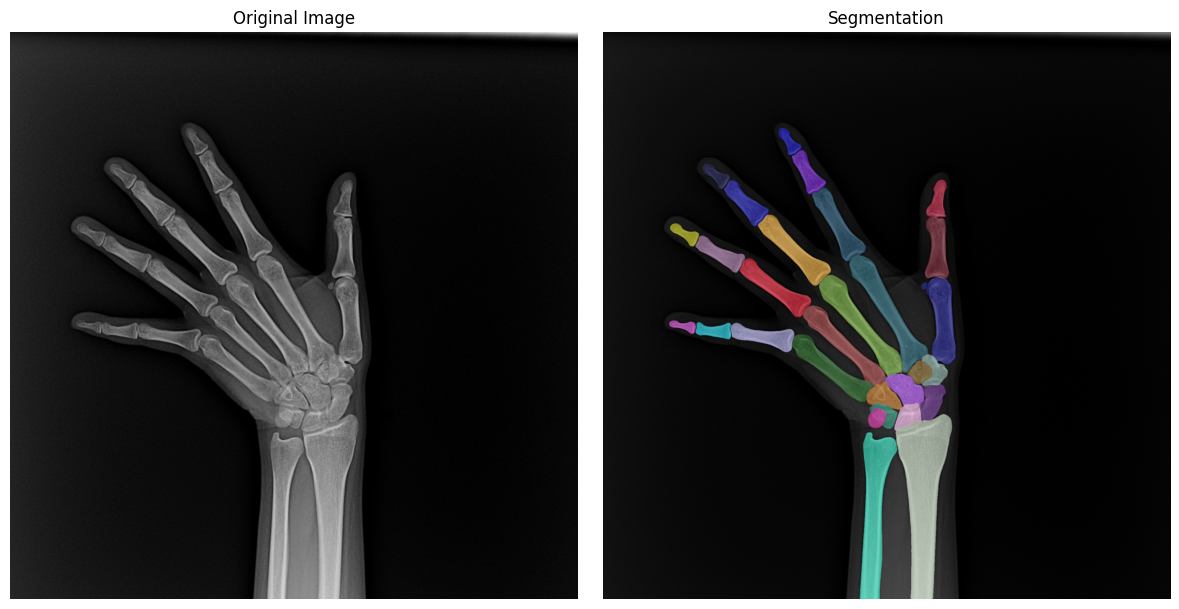

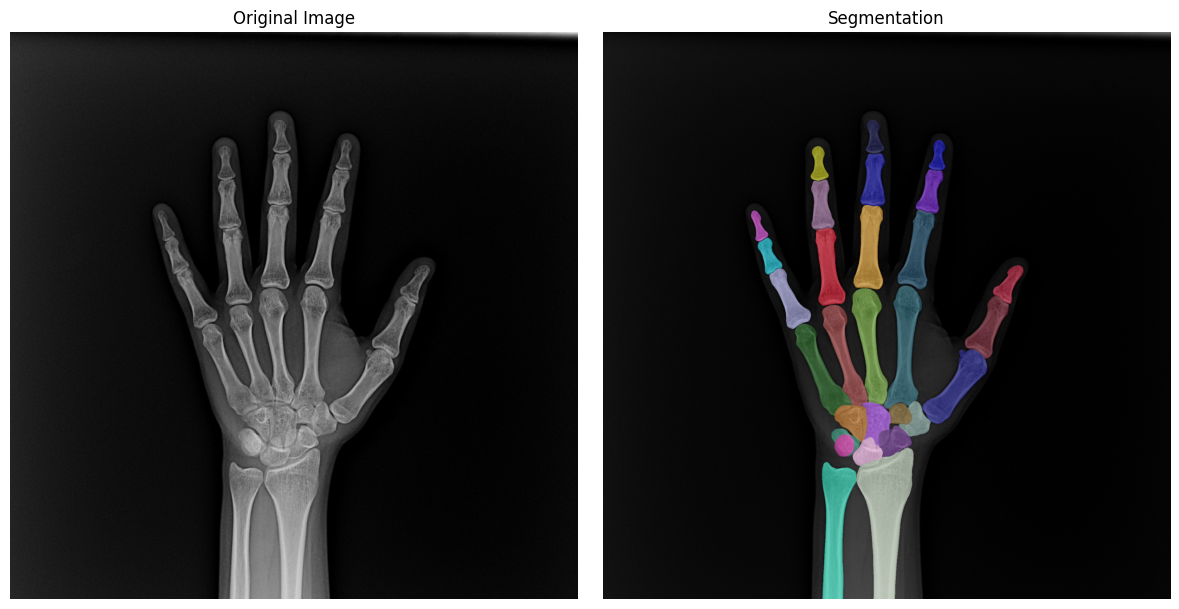

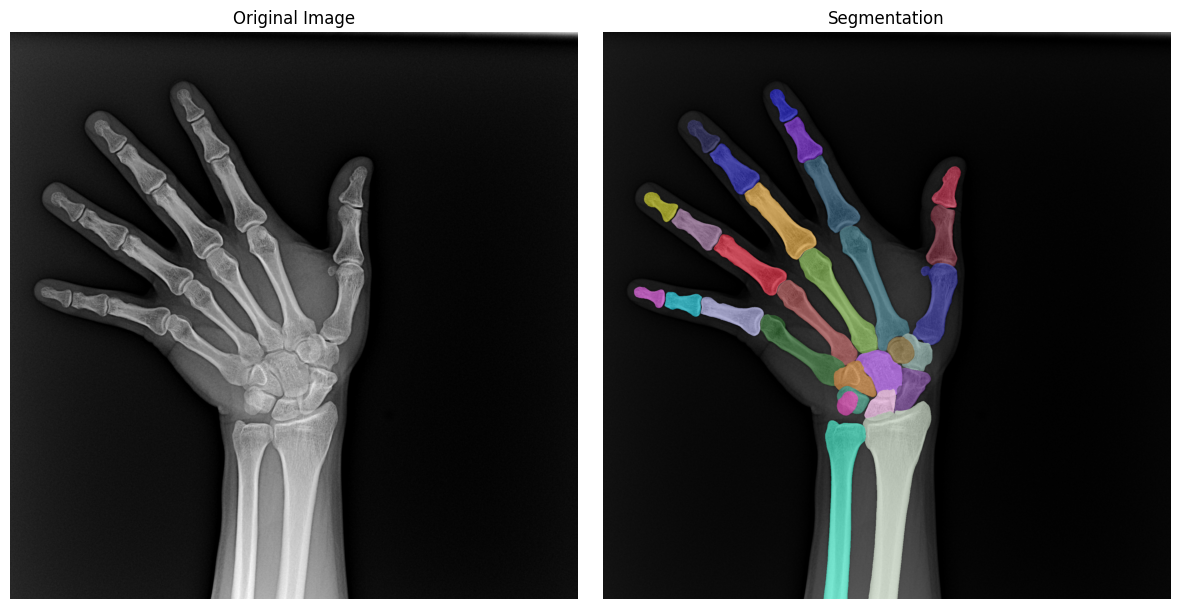

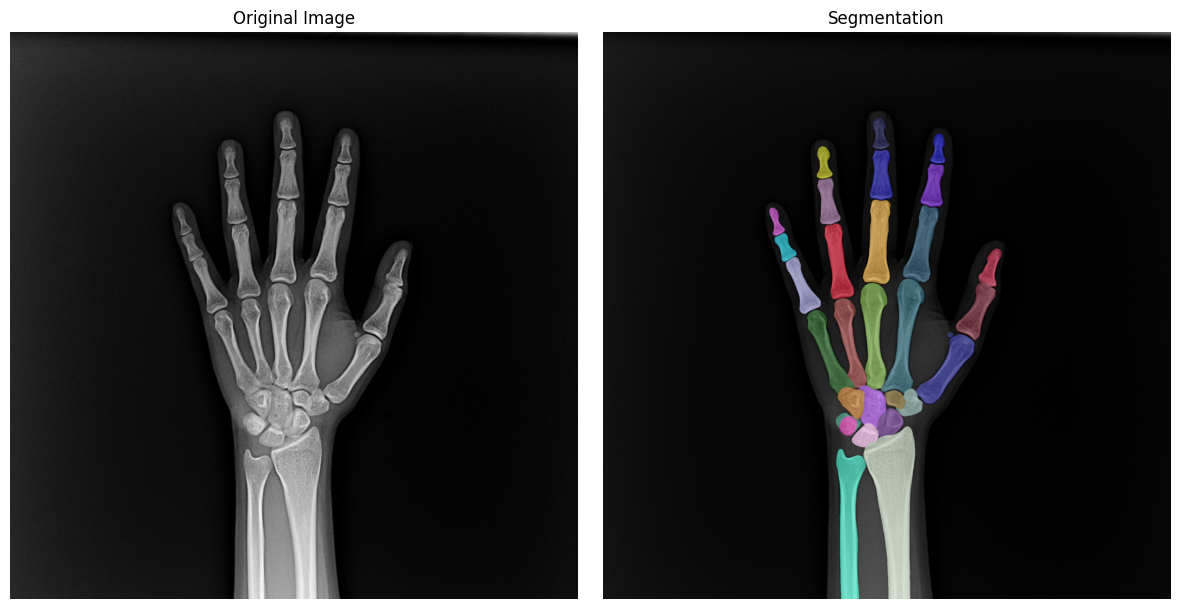

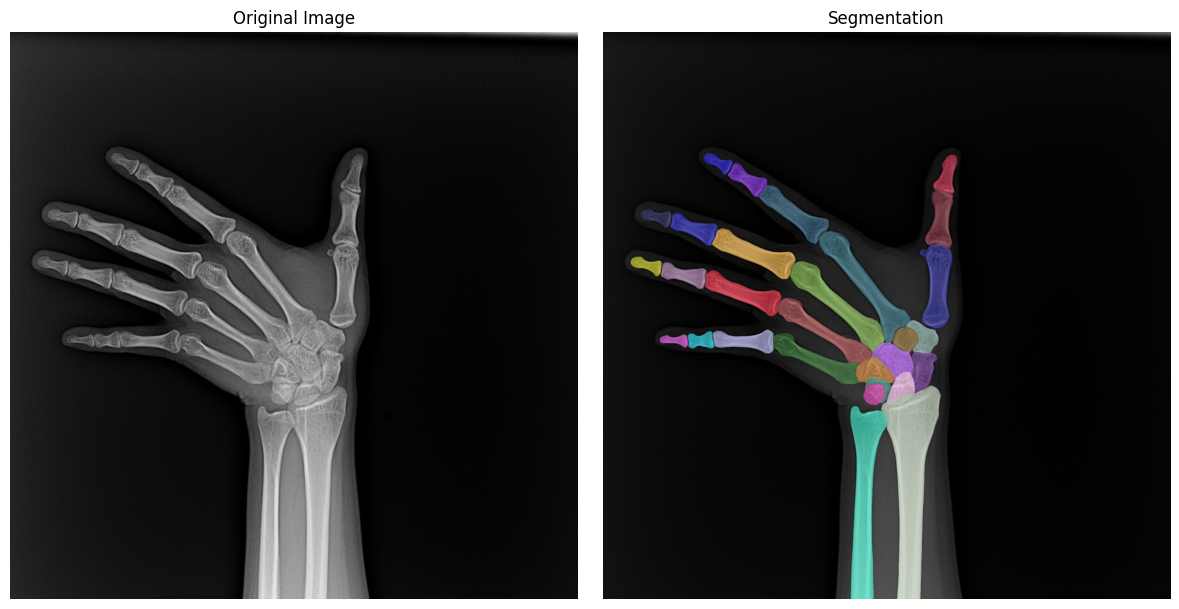

In [24]:

def display_segmentation_pair(image_path: str, segmentation_path: str) -> None:
    # 원본 이미지 로드
    image = np.array(Image.open(image_path).convert('RGB'))
    # 세그멘테이션 이미지 로드
    segmentation = np.array(Image.open(segmentation_path).convert('RGB'))
    
    # 플롯 설정
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(segmentation)
    axes[1].set_title("Segmentation")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_all_images_with_segmentations():
    segmentation_files = [f for f in os.listdir(output_dir) if f.endswith('_seg.png')]
    
    for i, seg_file in enumerate(segmentation_files[:5]): 
        image_name = seg_file.replace('_seg.png', '.png')  
        image_path = image_paths.get(image_name)  
        segmentation_path = os.path.join(output_dir, seg_file)
        
        if image_path is None:
            print(f"Original image not found: {image_name}")
            continue
        
        display_segmentation_pair(image_path, segmentation_path)


image_paths = load_image_paths()  

visualize_all_images_with_segmentations()
